In [3]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import pathlib
from numpy import asarray
from PIL import Image
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.13.0


In [4]:
base_dir = '../data/fruits-360/'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')

In [5]:
train_img_count = sum(len(files) for _, _, files in os.walk(train_dir))
test_img_count = sum(len(files) for _, _, files in os.walk(test_dir))

print(f'Number of files in the training folder: {train_img_count}')
print(f'Number of files in the test folder: {test_img_count}\n')

nr_classes = sorted((f for f in os.listdir(train_dir) if not f.startswith(".")), key=str.lower)

print(f'Number of classes: {len(nr_classes)}')
print(f'Names of classes: {nr_classes}')

Number of files in the training folder: 67693
Number of files in the test folder: 22689

Number of classes: 131
Names of classes: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'K

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Kiwi')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Pear')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Peach')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Avocado')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Blueberry')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Tomato 3')

(-0.5, 99.5, 99.5, -0.5)

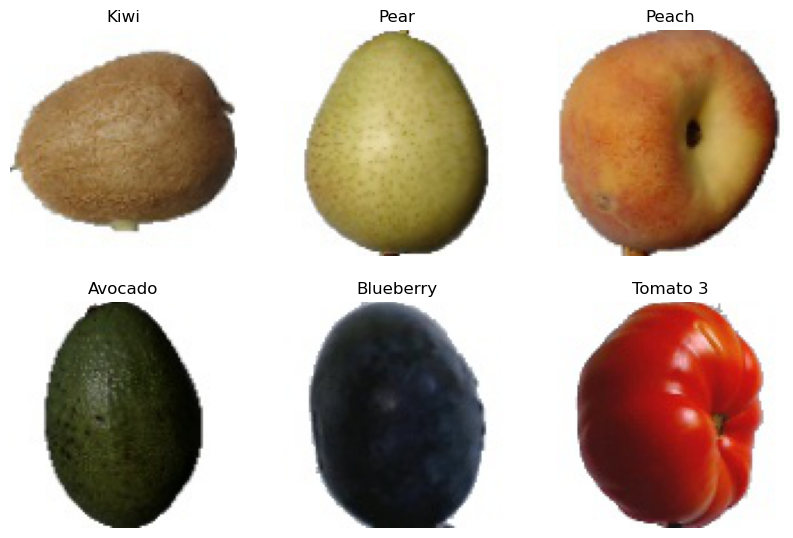

In [6]:
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

fruit6 = ['Kiwi', 'Pear', 'Peach', 'Avocado', 'Blueberry', 'Tomato 3']

plt.figure(figsize=(10, 10))

for i,fruit in enumerate (fruit6):    
    ax = plt.subplot(3, 3, i + 1)
    
    fruit_list = list(train_dir.glob(fruit + '/*'))
    
    plt.imshow(Image.open(str(fruit_list[i])))
    plt.title(fruit6[i])
    plt.axis("off")    

In [7]:
# Loading the dataset

def load_fruits360(path):
    data_loading = load_files(path)
    files = np.array(data_loading['filenames'])
    target_fruits = np.array(data_loading['target'])
    target_labels_fruits = np.array(data_loading['target_names'])
    
    return files, target_fruits, target_labels_fruits

X_train, y_train, target_labels = load_fruits360(train_dir)
X_test, y_test, _ = load_fruits360(test_dir)

In [8]:
print(f'Number of classes: {len(np.unique(y_train))}')

X_train.shape
y_train.shape
X_test.shape
y_test.shape

Number of classes: 131


(67692,)

(67692,)

(22688,)

(22688,)

In [9]:
# Splitting the test set into validation and test set (ratio 1/2)

#X_test, X_valid = X_test[11344:],X_test[:11344]
#y_test, y_vaild = y_test[11344:],y_test[:11344]

# Splitting the training set into validation and training set (10000 validation)

X_train, X_valid, y_train, y_valid  = train_test_split(X_train, y_train, test_size = 0.20, random_state = 1)

In [10]:
def convert_image_to_nparray(files):
    images = []
    for file in files:
        images.append(asarray(Image.open(file)))
    return images

X_train = np.array(convert_image_to_nparray(X_train))
print(f'Training set shape: {X_train.shape}')

X_valid = np.array(convert_image_to_nparray(X_valid))
print(f'Validation set shape: {X_valid.shape}')

X_test = np.array(convert_image_to_nparray(X_test))
print(f'Test set shape: {X_test.shape}')


Training set shape: (54153, 100, 100, 3)
Validation set shape: (13539, 100, 100, 3)
Test set shape: (22688, 100, 100, 3)


In [11]:
# Nr classes, image height and width

num_classes = len(target_labels)

img_height = 100
img_width = 100

In [12]:
# Create the model 
from tensorflow.keras.models import Sequential

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

2024-09-03 18:18:38.558065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-03 18:18:38.558105: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-03 18:18:38.558115: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-03 18:18:38.558620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-03 18:18:38.559040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# Model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

In [22]:
# Train the model

history = model.fit(
  X_train, # Train images
  y_train, # Train labels
  batch_size = 32,
  epochs = 10,
  validation_data = (X_valid, y_valid), # Validation images & labels
)


Epoch 1/10
1693/1693 [==============================] - 29s 17ms/step - loss: 25.4695 - accuracy: 0.9942 - val_loss: 9.5841 - val_accuracy: 0.9973
Epoch 2/10
1693/1693 [==============================] - 33s 19ms/step - loss: 20.9502 - accuracy: 0.9952 - val_loss: 48.2918 - val_accuracy: 0.9900
Epoch 3/10
1693/1693 [==============================] - 27s 16ms/step - loss: 27.0745 - accuracy: 0.9948 - val_loss: 4.5484 - val_accuracy: 0.9989
Epoch 4/10
1693/1693 [==============================] - 28s 17ms/step - loss: 21.5249 - accuracy: 0.9958 - val_loss: 20.2916 - val_accuracy: 0.9955
Epoch 5/10
1693/1693 [==============================] - 27s 16ms/step - loss: 29.5722 - accuracy: 0.9957 - val_loss: 14.4908 - val_accuracy: 0.9972
Epoch 6/10
1693/1693 [==============================] - 28s 17ms/step - loss: 20.4087 - accuracy: 0.9963 - val_loss: 16.5453 - val_accuracy: 0.9968
Epoch 7/10
1693/1693 [==============================] - 26s 15ms/step - loss: 40.3301 - accuracy: 0.9953 - val_los

709/709 [==============================] - 5s 7ms/step - loss: 1014.3214 - accuracy: 0.9555
Test accuracy: 0.955


<Figure size 1600x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Training and Validation Accuracy')

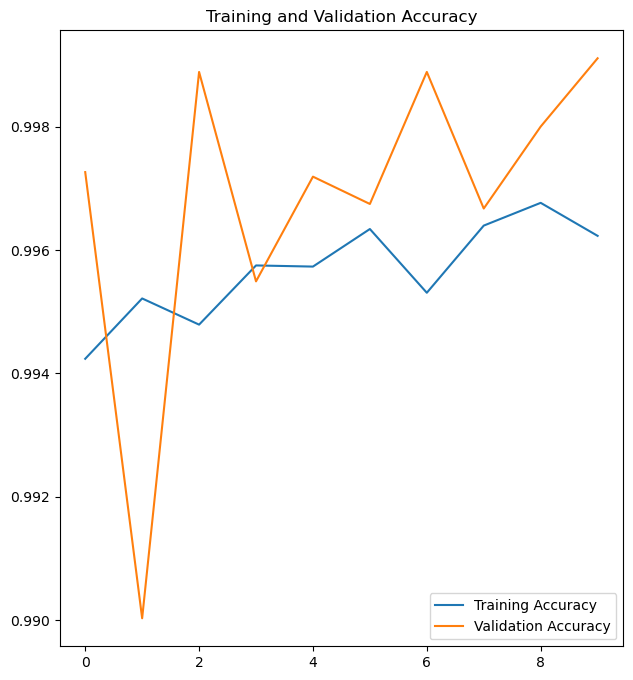

In [23]:
# Accuracy on test set

accuracy = model.evaluate(X_test, y_test) # Test the model
print(f'Test accuracy: {accuracy[1]:.3f}')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [24]:
# Save model

model.save('../models/cnn-split-train-val')
model.save('../baseline_cnn/cnn-split-train-val')

INFO:tensorflow:Assets written to: ../models/cnn-split-train-val/assets


INFO:tensorflow:Assets written to: ../models/cnn-split-train-val/assets


In [25]:
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('models.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/n0/t16244hs7cs_6x3cvcpgz3h40000gn/T/tmpx_t3t22s/assets


INFO:tensorflow:Assets written to: /var/folders/n0/t16244hs7cs_6x3cvcpgz3h40000gn/T/tmpx_t3t22s/assets
2024-09-03 19:03:17.010631: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-09-03 19:03:17.010938: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-09-03 19:03:17.012308: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/n0/t16244hs7cs_6x3cvcpgz3h40000gn/T/tmpx_t3t22s
2024-09-03 19:03:17.013243: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-09-03 19:03:17.013248: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/n0/t16244hs7cs_6x3cvcpgz3h40000gn/T/tmpx_t3t22s
2024-09-03 19:03:17.017682: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-09-03 19:03:17.074449: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

4884996

In [26]:
# Predictions

# model = keras.models.load_model('../models/cnn') # Load model

predictions = model.predict(X_test)

 20/709 [..............................] - ETA: 3s

2024-09-03 19:03:28.459590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


709/709 [==============================] - 3s 4ms/step


In [31]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image

from tensorflow.keras.preprocessing import image

model = keras.models.load_model('../models/cnn-split-train-val')

img = tf.keras.preprocessing.image.load_img('../random-test/banana_white.png', target_size=(100, 100))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(target_labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 42ms/step
This image most likely belongs to Carambula with a 100.00 percent confidence.


2024-09-03 19:05:57.515807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

Text(0.5, 1.0, 'Index out of bounds')

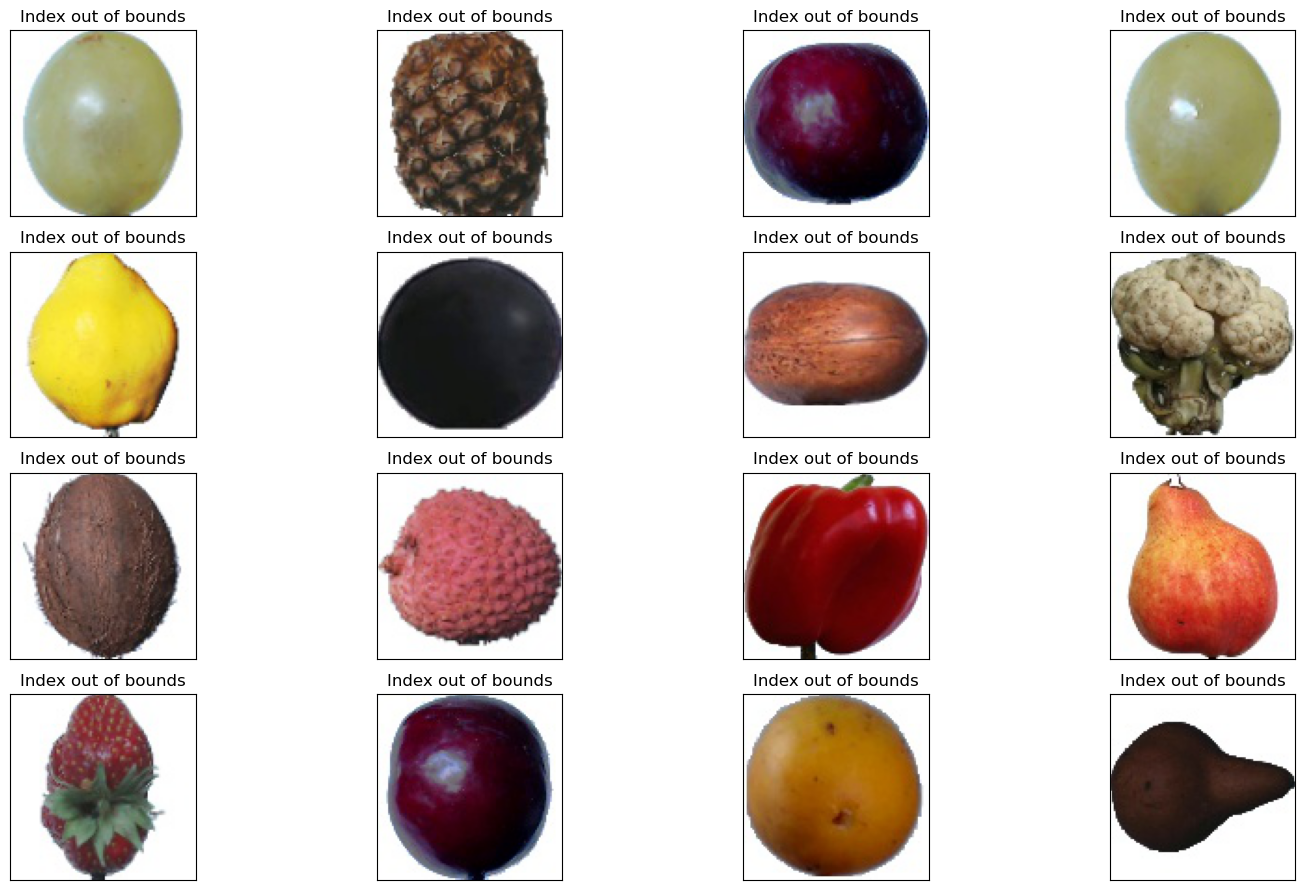

In [34]:
# Plot random images with predictions scores

# Plotting predictions
fig = plt.figure(figsize=(16, 9))  # Set to original figsize (16, 9)
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))

    # Check if idx is within bounds of predictions
    if idx < len(predictions):
        pred_idx = np.argmax(predictions[idx])
        score = tf.nn.softmax(predictions[idx])
        ax.set_title("{}, Confidence: {:.2f}".format(target_labels[pred_idx], 100 * np.max(score)))
    else:
        ax.set_title("Index out of bounds")

plt.tight_layout()
plt.show()


In [35]:
# Data augmentation to avoid overfitting -> create new neural network (add dropout layer)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                 

In [38]:
# Increase epochs - training stops 

history = model.fit(
  X_train,
  y_train,
  batch_size = 32,
  epochs = 100,
  validation_data = (X_valid, y_valid),
  verbose = 1 
)


Epoch 1/5
1693/1693 [==============================] - 62s 36ms/step - loss: 20.0582 - accuracy: 0.9492 - val_loss: 6.5752 - val_accuracy: 0.9764
Epoch 2/5
1693/1693 [==============================] - 72s 42ms/step - loss: 23.0768 - accuracy: 0.9533 - val_loss: 29.0109 - val_accuracy: 0.9538
Epoch 3/5
1693/1693 [==============================] - 59s 35ms/step - loss: 27.5785 - accuracy: 0.9550 - val_loss: 50.0654 - val_accuracy: 0.9257
Epoch 4/5
1693/1693 [==============================] - 56s 33ms/step - loss: 28.6451 - accuracy: 0.9615 - val_loss: 36.4635 - val_accuracy: 0.9534
Epoch 5/5
1693/1693 [==============================] - 58s 34ms/step - loss: 35.8103 - accuracy: 0.9606 - val_loss: 12.4403 - val_accuracy: 0.9840


In [43]:
model.save('../baseline_cnn/cnn-data-augmented') # Save model
model.save('../models/cnn-data-augmented')

INFO:tensorflow:Assets written to: ../baseline_cnn/cnn-data-augmented/assets


INFO:tensorflow:Assets written to: ../baseline_cnn/cnn-data-augmented/assets
